In [9]:
# Read the log file into a pandas DataFrame, split pid:tid into separate columns
import pandas as pd

def read_log(path):
    df = pd.read_csv(path, header=None, names=["pname", "pid", "tid", "syscall", "rcx", "rdx", "r8", "r9"])
    return df

df = read_log('logs/ransomwarePOC_60s.log')


In [10]:
# Read the system call names from the csv files
# csv files are from: https://github.com/j00ru/windows-syscalls

# Client OS Windows 10 Version:
CLIENT_OS = 'Windows 10 (21H2)'

nt = pd.read_csv('nt.csv', usecols=['System call', CLIENT_OS])
nt = nt.dropna()

win32k = pd.read_csv('win32k.csv', usecols=['System call', CLIENT_OS])
win32k = win32k.dropna()
nt = pd.concat([nt, win32k], ignore_index=True)


In [11]:
# merge logs with system call names
df['syscall'] = df['syscall'].apply(lambda x: int(x, 16))
nt[CLIENT_OS] = nt[CLIENT_OS].astype(str).str.replace('0x', '', regex=False)
nt[CLIENT_OS] = nt[CLIENT_OS].apply(lambda x: int(x, 16))

df = pd.merge(df, nt, left_on='syscall', right_on=CLIENT_OS, how='left', validate='many_to_one')
df = df.drop(columns=[CLIENT_OS])
df['syscall'] = df['syscall'].apply(lambda x: hex(x)[2:])

In [12]:
# Filter for interesting process
filtered_df = df[df['pid'] == '2118']
filtered_df


,pname,pid,tid,syscall,rcx,rdx,r8,r9,System call
44,RansomwarePOC.,2118,22e8,49,18c,bbcc34a390,bbcc34a3b0,8,NtQueryVolumeInformationFile
89,RansomwarePOC.,2118,22e8,27,188,bbcc34b1a8,bbcc34b1a0,8,NtSetInformationFile
90,RansomwarePOC.,2118,22e8,8,188,0,0,0,NtWriteFile
91,RansomwarePOC.,2118,22e8,11,188,bbcc34b1d8,bbcc34b1d0,8,NtQueryInformationFile
92,RansomwarePOC.,2118,22e8,27,188,bbcc34b1d8,bbcc34b1d0,8,NtSetInformationFile
...,...,...,...,...,...,...,...,...,...
2094,RansomwarePOC.,2118,22e8,11,244,bbcc34b188,bbcc34b180,8,NtQueryInformationFile
2095,RansomwarePOC.,2118,22e8,27,244,bbcc34b188,bbcc34b180,8,NtSetInformationFile
2096,RansomwarePOC.,2118,22e8,6,244,0,0,0,NtReadFile
2097,RansomwarePOC.,2118,22e8,11,244,bbcc34b1a8,bbcc34b1a0,8,NtQueryInformationFile


<Axes: title={'center': 'System calls issued by RansomwarePOC'}, xlabel='Number of system calls'>

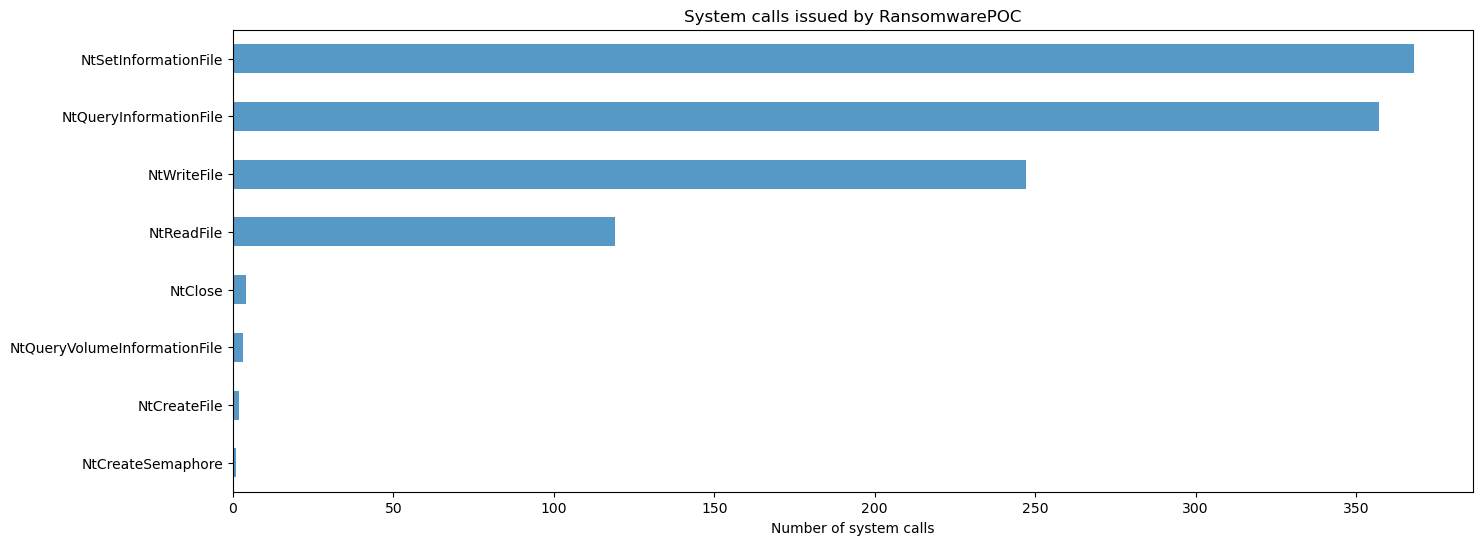

In [42]:
# Detailed view what system calls are called by RansomwarePOC
grouped_df = filtered_df.groupby(['System call']).size()
grouped_df=grouped_df.sort_values(ascending=True)
grouped_df.plot(
        kind='barh', figsize=(16,6), title='System calls issued by RansomwarePOC',xlabel='Number of system calls', ylabel='', alpha=0.75
    )

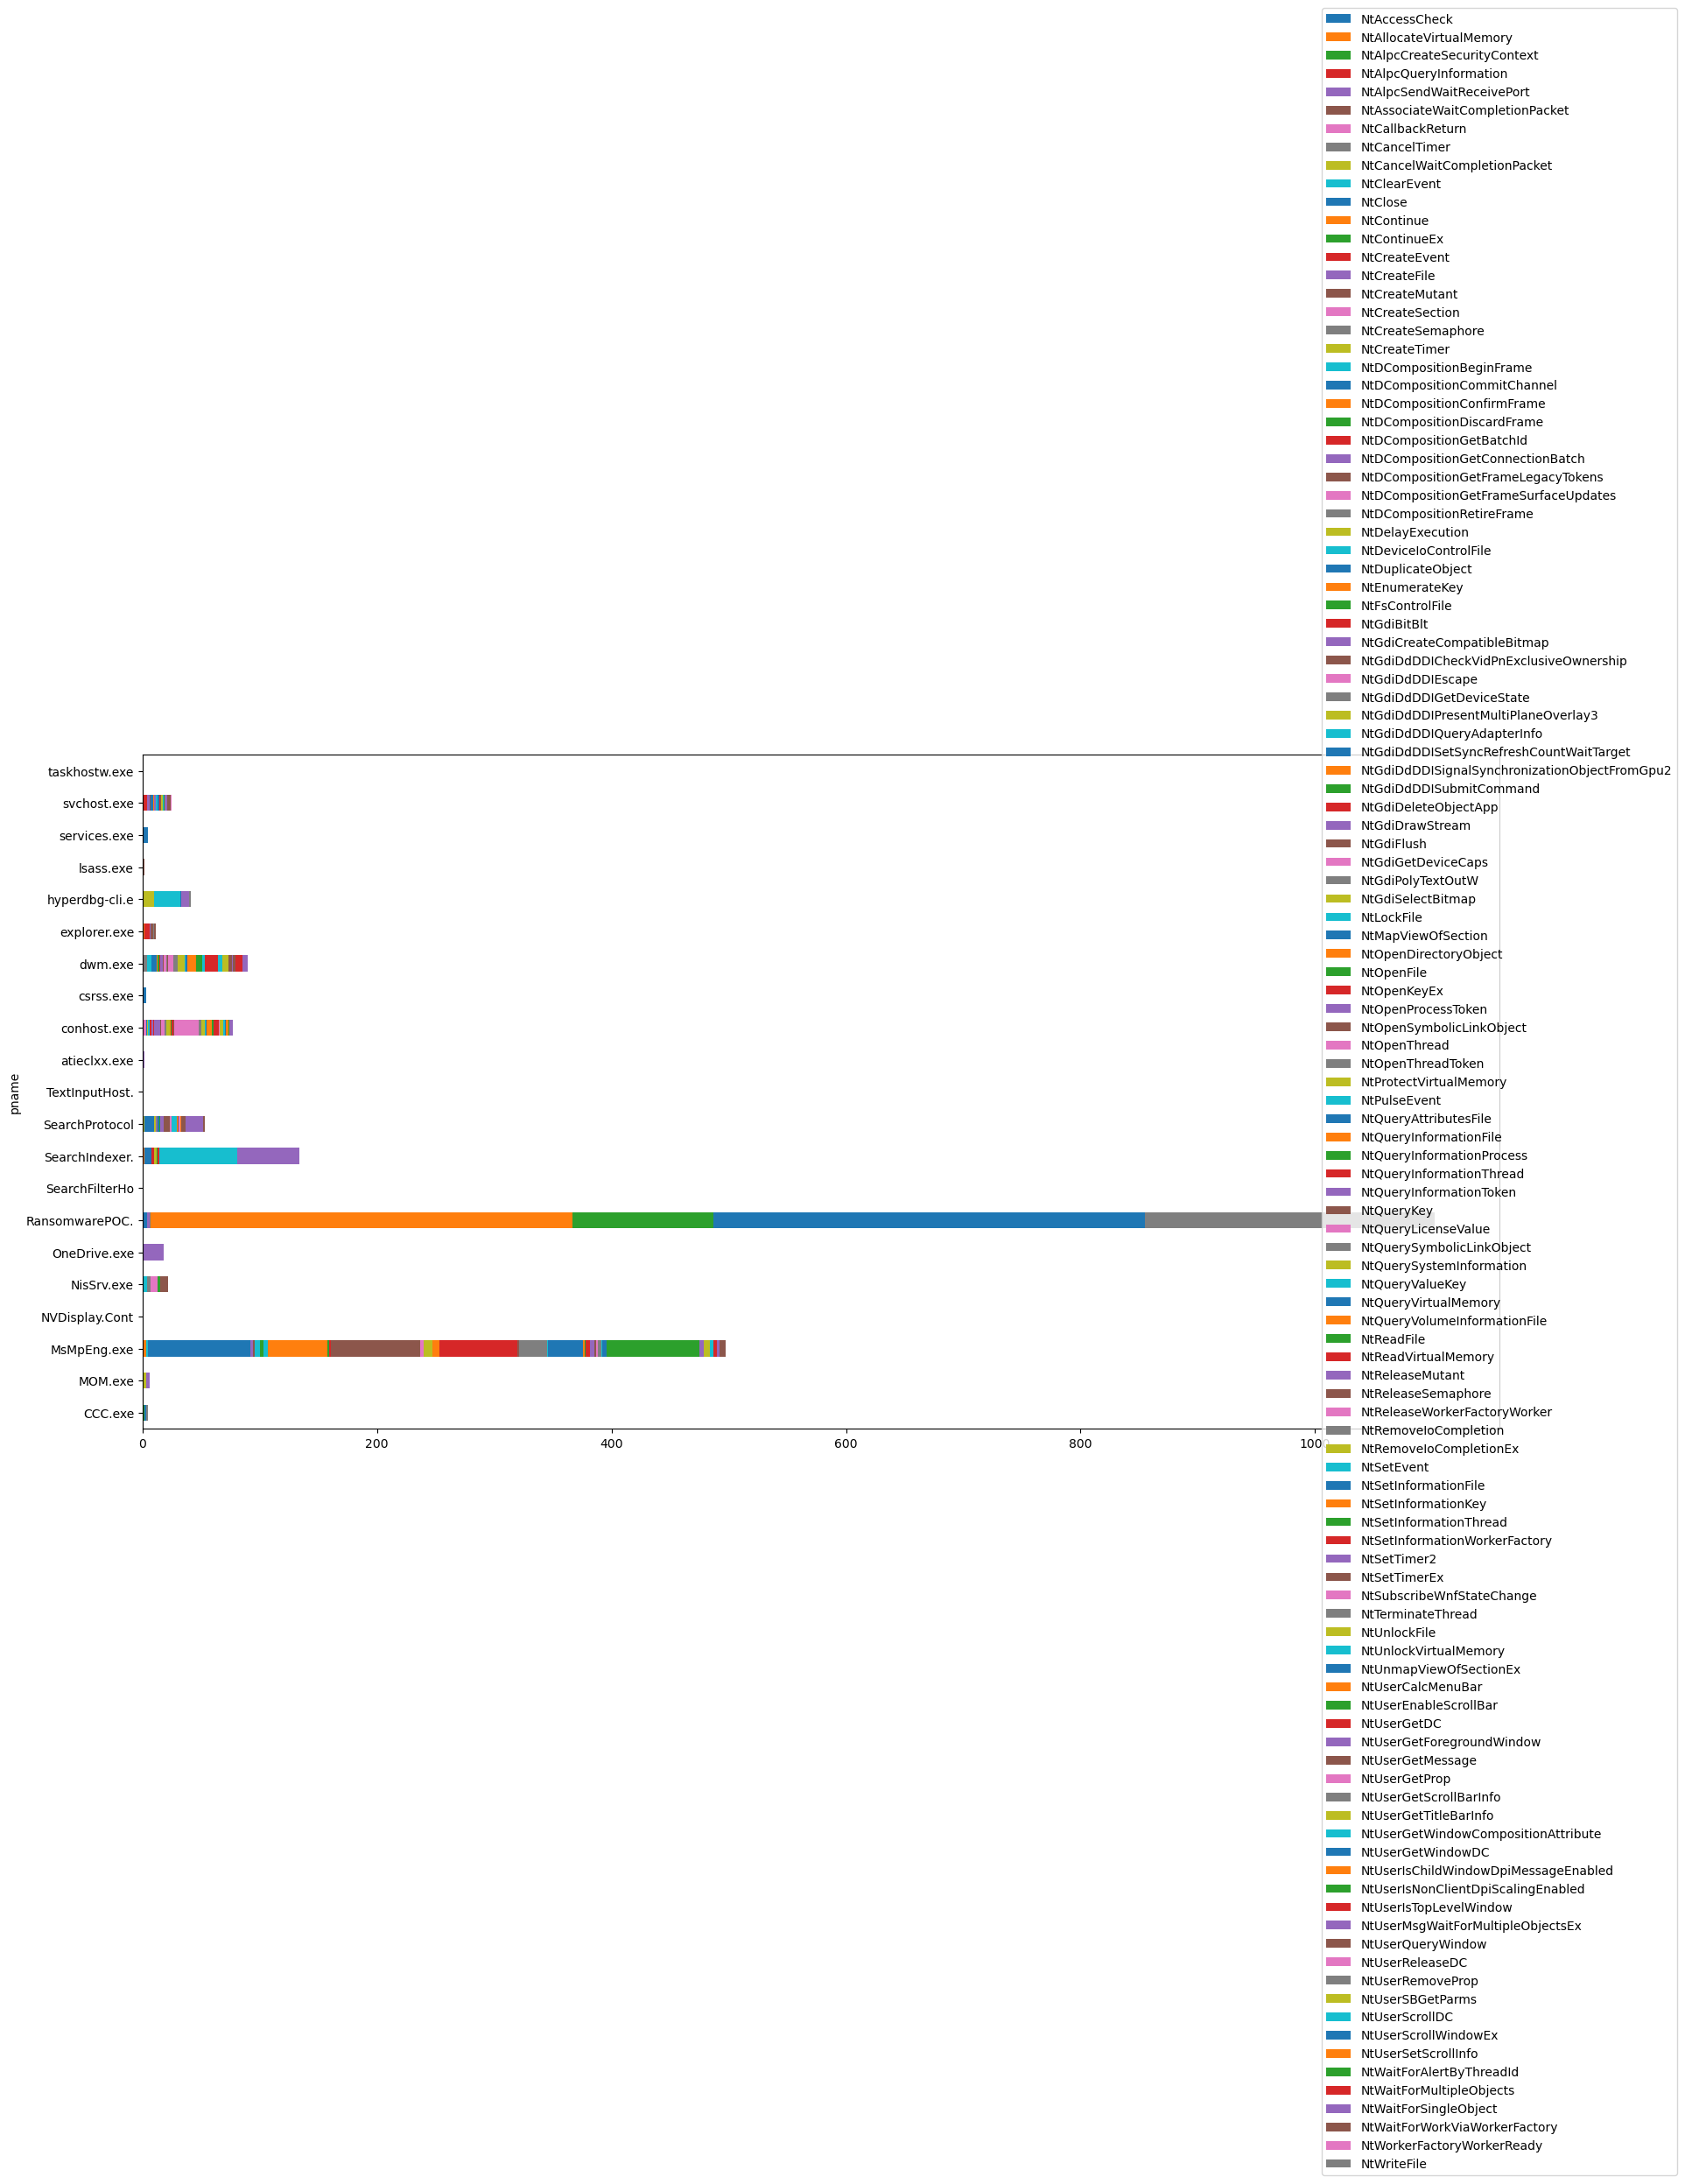

In [32]:
# Messy overview what system calls are called per process
grouped_df = df.groupby(['System call', 'pname']).size().reset_index(name='count')
grouped_df.pivot_table(
        index='pname', columns='System call', values='count', fill_value=0
    ).plot(
        kind='barh', figsize=(20, 10), stacked=True, 
    ).legend(loc='center', bbox_to_anchor=(1, 0.5))

<Axes: title={'center': 'Number of system calls issued by each process'}, xlabel='Number of system calls'>

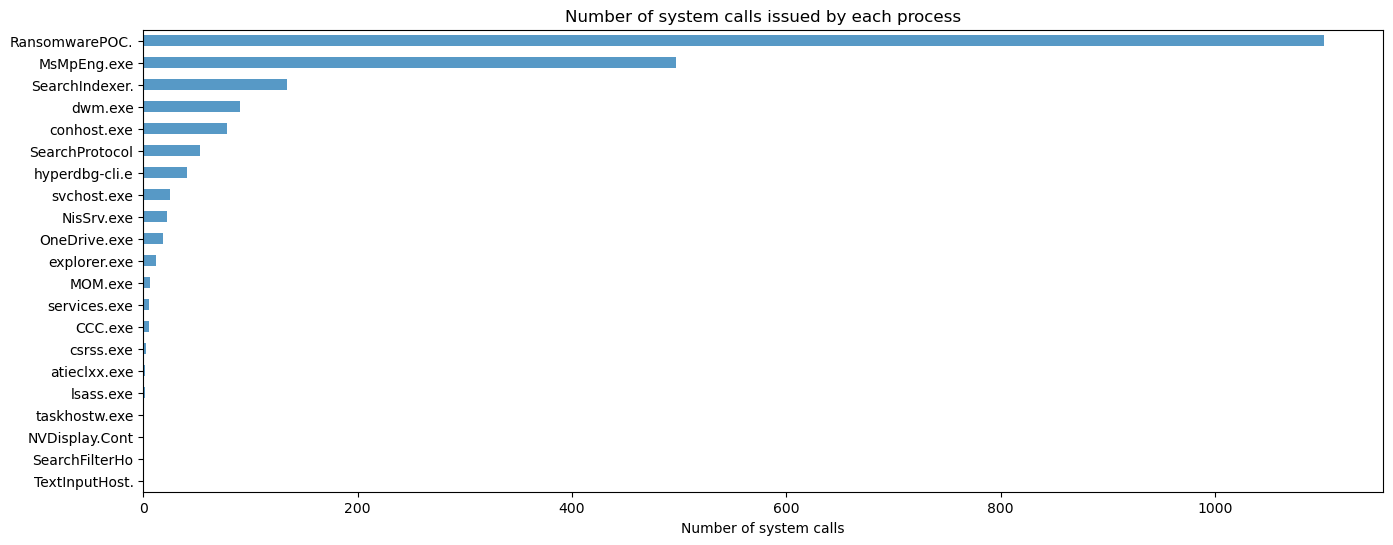

In [43]:
# How many system calls are called by RansomwarePOC compared to other processes
grouped_df = df.groupby(['pname']).size().reset_index(name='count')
grouped_df = grouped_df.sort_values(by='count', ascending=True)
grouped_df.plot(
        kind='barh', x='pname', y='count', figsize=(16,6), title='Number of system calls issued by each process', xlabel='Number of system calls', ylabel='', legend=False, alpha=0.75
    )

<Axes: title={'center': 'Number of system calls issued by each process with small files'}, xlabel='Number of system calls'>

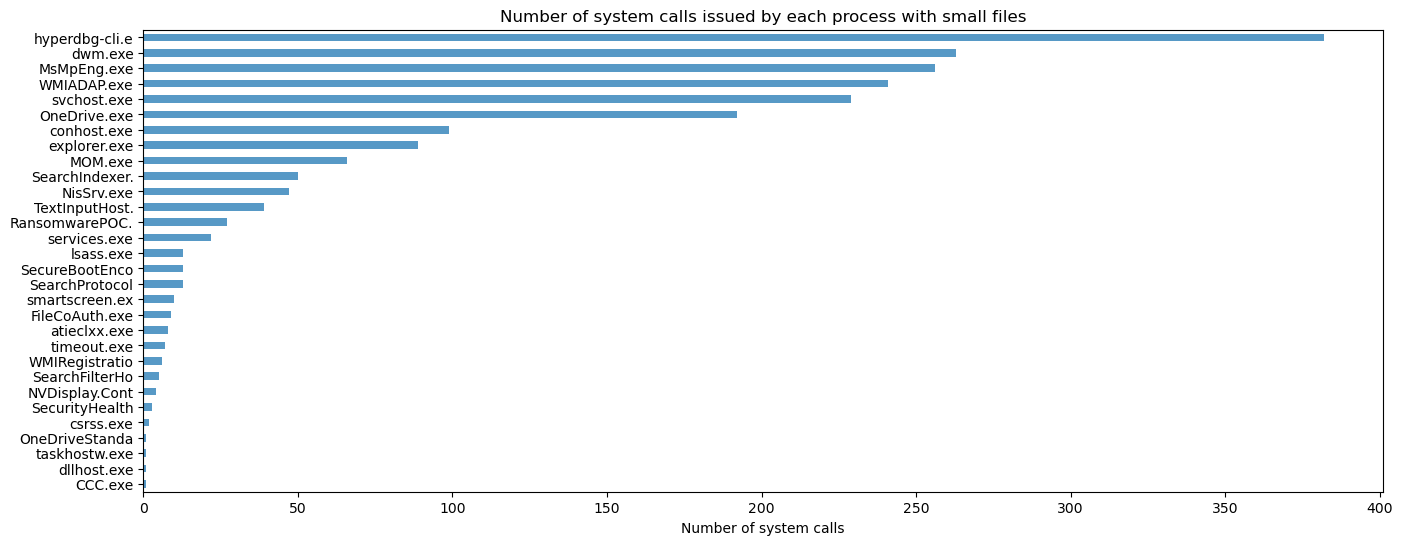

In [48]:
# How many system calls are called by RansomwarePOC compared to other processes with small files
df_small = read_log('logs/ransomwarePOC_small_files_60s.log')
df_small['syscall'] = df_small['syscall'].apply(lambda x: int(x, 16))
df_small = pd.merge(df_small, nt, left_on='syscall', right_on=CLIENT_OS, how='left', validate='many_to_one')
df_small = df_small.drop(columns=[CLIENT_OS])
df_small['syscall'] = df_small['syscall'].apply(lambda x: hex(x)[2:])

grouped_df = df_small.groupby(['pname']).size().reset_index(name='count')
grouped_df = grouped_df.sort_values(by='count', ascending=True)
grouped_df.plot(
        kind='barh', x='pname', y='count', figsize=(16,6), title='Number of system calls issued by each process with small files', xlabel='Number of system calls', ylabel='', legend=False, alpha=0.75
    )
